In [1]:
%matplotlib inline

In [40]:
import hddm
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
data = hddm.load_csv('./data/cavanagh_theta_nn.csv')
data.head(10)

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
5,0,WL,1.150,1.0,-0.436204,1,LC
6,0,LL,2.000,1.0,-0.274479,1,HC
7,0,WL,1.040,0.0,0.666957,1,LC
8,0,WW,0.857,1.0,0.118617,1,HC
9,0,WL,1.500,0.0,0.823626,1,LC


## Starting with running `hddm` on the data

In [4]:
m = hddm.HDDM(data) #, p_outlier=.05)
m.find_starting_values()
m.sample(2000, burn=500)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 132.2 sec

/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [6]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.05551,0.106839,1.8555,1.99169,2.05348,2.11619,2.27234,0.0028596
a_std,0.378822,0.0940103,0.248622,0.314791,0.363159,0.422273,0.634376,0.0035783
a_subj.0,2.38267,0.0603338,2.26902,2.34145,2.38262,2.42271,2.50249,0.00178341
a_subj.1,2.12827,0.0645233,2.00346,2.08417,2.12773,2.1713,2.25561,0.00236367


Plotting a
Plotting a_std
Plotting v
Plotting t


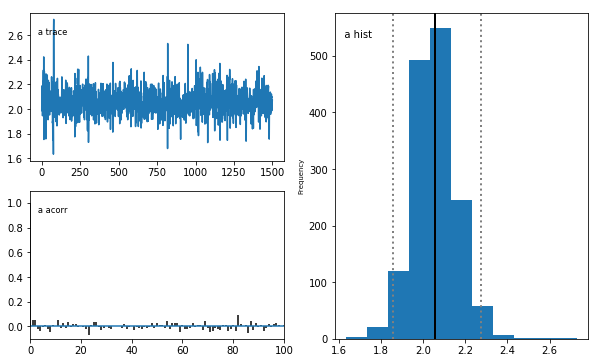

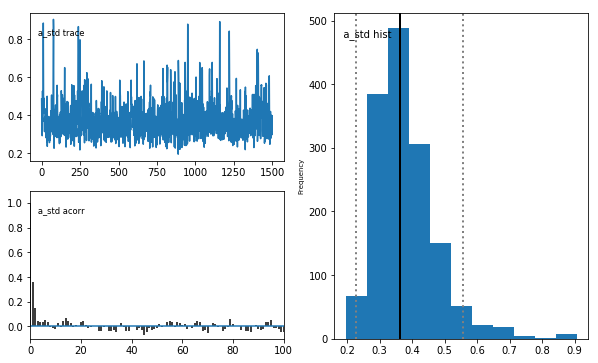

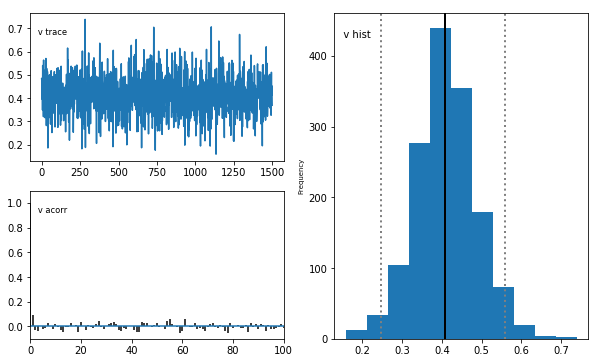

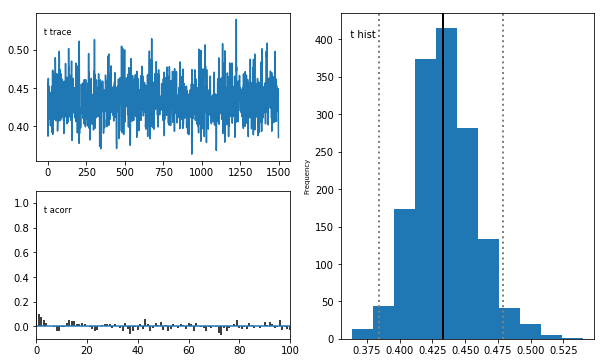

In [7]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])


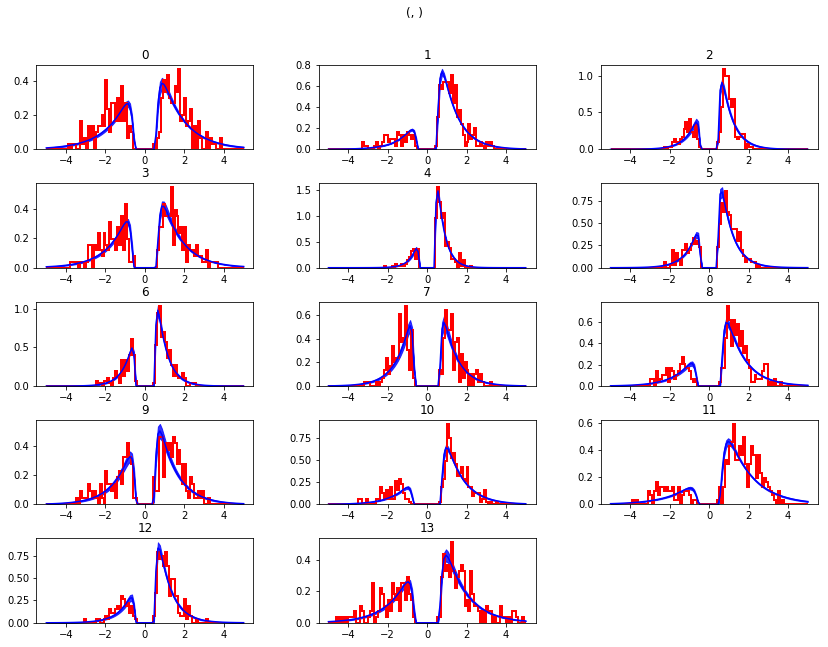

In [8]:
m.plot_posterior_predictive(figsize=(14, 10))


In [9]:
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 1351.1 sec

/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means')

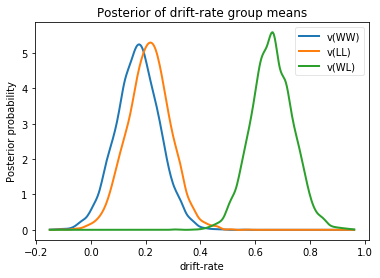

In [10]:
v_WW, v_LL, v_WL = m_stim.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

## Now let's try simulating the same result in raw PyMC3

0       1.210
1       1.630
2       1.030
3       2.770
4       1.140
5       1.150
6       2.000
7       1.040
8       0.857
9       1.500
10      1.720
11      0.656
12      1.720
13      1.720
14      1.360
15      1.570
16      2.440
17      2.360
18      1.380
19      1.010
20      0.987
21      1.010
22      2.380
23      1.510
24      1.170
25      1.880
26      1.050
27      3.250
28      1.530
29      0.972
        ...  
3958    1.890
3959    1.330
3960    1.830
3961    2.690
3962    1.790
3963    3.610
3964    2.290
3965    2.760
3966    2.130
3967    3.250
3968    1.420
3969    2.170
3970    4.840
3971    2.230
3972    1.110
3973    0.791
3974    0.803
3975    1.220
3976    1.970
3977    1.720
3978    1.880
3979    1.660
3980    1.890
3981    1.590
3982    1.460
3983    1.450
3984    0.711
3985    0.784
3986    2.350
3987    1.250
Name: rt, Length: 3988, dtype: float64

In [39]:
hddm_model = pm.Model()
num_subjects = len(set(data.subj_idx))
subject_idx = data.subj_idx.values
rts = data['rt'].values

wiener_params = {'err': 1e-4, 'n_st':2, 'n_sz':2,
                 'use_adaptive':1,
                 'simps_err':1e-3,
                 'w_outlier': 0.1}
cdf_bound = max(np.abs(data['rt'])) + 1
wfpt_class = hddm.likelihoods.Wfpt


with hddm_model:
    # Let's specify some priors
    mu_a = pm.Gamma('mu_a', mu=1.5, sd=0.75)
    sigma_a = pm.HalfNormal('sigma_a', sd=0.1)
    
    mu_v = pm.Normal('mu_v', mu=2, sd=3)
    sigma_v = pm.HalfNormal('sigma_v', sd=2)
    
    mu_z = pm.Normal('mu_z', mu=0.5, sd=0.5)
    sigma_z = pm.HalfNormal('sigma_z', sd=0.05)
    
    mu_t = pm.Gamma('mu_t', mu=0.4, sd=0.2)
    sigma_t = pm.HalfNormal('sigma_t', sd=1)
    
    sv = pm.HalfNormal('sv', sd=2)
    st = pm.HalfNormal('st', sd=0.3)
    sz = pm.Beta('sz', alpha=1, beta=3)
    
    a = pm.Gamma('a', mu=mu_a, sd=sigma_a, shape=num_subjects)
    v = pm.Normal('v', mu=mu_v, sd=sigma_v, shape=num_subjects)
    z_raw = pm.Normal('z_raw', mu=mu_z, sd=sigma_z, shape=num_subjects)
    z = pm.Deterministic('z', pm.invlogit(z_raw))
    t = pm.Normal('t', mu=mu_t, sd=sigma_t, shape=num_subjects)

    # TODO: figure out how to set up the likelihood function here, and pass it all the parameters
    
    def pymc3_likelihood(v, sv, a, z, sz, t, st):
        wiener_params = {'err': 1e-4, 'n_st':2, 'n_sz':2,
                         'use_adaptive':1,
                         'simps_err':1e-3,
                         'w_outlier': 0.1}
        def logp_(x):
            return hddm.wfpt.wiener_like(x, v, sv, a, z, sz, t, st, err=1e-4)
        
        return logp_
 
    x = pm.DensityDist('x', pymc3_likelihood(v, sv, a, z, sz, t, st), observed=rts)
#    x = hddm.likelihoods.Wfpt('x', v, sv, a, z, sz, t, st, value=data, observed=True)
    

    # TODO: sample
    # TODO: plot and see that similar
    
    


TypeError: must be real number, not FreeRV

In [13]:
with hddm_model:
    hddm_trace = pm.sample(draws=2000, n_init=1000)


In [38]:
?